## Data Preparation 

In [320]:
using JuliaDB
using VegaDatasets
using Plots
using Statistics
using Flux
using DataFrames

In [140]:
cars = dataset("cars") |> table

Table with 406 rows, 9 columns:
Columns:
#  colname           type
────────────────────────────────────────────
1  Name              String
2  Miles_per_Gallon  Union{Missing, Float64}
3  Cylinders         Int64
4  Displacement      Float64
5  Horsepower        Union{Missing, Int64}
6  Weight_in_lbs     Int64
7  Acceleration      Float64
8  Year              String
9  Origin            String

In [141]:
ML.schema(cars)

Dict{Symbol,Any} with 9 entries:
  :Cylinders        => Continous(μ=5.475369458128076, σ=1.7121596315485288)
  :Horsepower       => Maybe{Continuous}(Continous(μ=105.08250000000002, σ=38.7…
  :Displacement     => Continous(μ=194.77955665024618, σ=104.92245837948875)
  :Weight_in_lbs    => Continous(μ=2979.4137931034484, σ=847.0043282393509)
  :Miles_per_Gallon => Maybe{Continuous}(Continous(μ=23.514572864321607, σ=7.81…
  :Year             => nothing
  :Acceleration     => Continous(μ=15.51970443349754, σ=2.803358816342545)
  :Origin           => nothing
  :Name             => nothing

In [142]:
cars_schema = ML.schema(cars,hints = Dict(
        :Cylinders => ML.Categorical,
        :Origin => ML.Categorical
    )
)

Dict{Symbol,Any} with 9 entries:
  :Cylinders        => Categorical([8, 4, 6, 3, 5])
  :Horsepower       => Maybe{Continuous}(Continous(μ=105.08250000000002, σ=38.7…
  :Displacement     => Continous(μ=194.77955665024618, σ=104.92245837948875)
  :Weight_in_lbs    => Continous(μ=2979.4137931034484, σ=847.0043282393509)
  :Miles_per_Gallon => Maybe{Continuous}(Continous(μ=23.514572864321607, σ=7.81…
  :Year             => nothing
  :Acceleration     => Continous(μ=15.51970443349754, σ=2.803358816342545)
  :Origin           => Categorical(["USA", "Europe", "Japan"])
  :Name             => nothing

In [143]:
input_schema, output_schema = ML.splitschema(cars_schema,:Weight_in_lbs);

In [144]:
input_schema

Dict{Symbol,Any} with 8 entries:
  :Cylinders        => Categorical([8, 4, 6, 3, 5])
  :Horsepower       => Maybe{Continuous}(Continous(μ=105.08250000000002, σ=38.7…
  :Displacement     => Continous(μ=194.77955665024618, σ=104.92245837948875)
  :Origin           => Categorical(["USA", "Europe", "Japan"])
  :Miles_per_Gallon => Maybe{Continuous}(Continous(μ=23.514572864321607, σ=7.81…
  :Year             => nothing
  :Acceleration     => Continous(μ=15.51970443349754, σ=2.803358816342545)
  :Name             => nothing

In [145]:
output_schema

Dict{Symbol,Any} with 1 entry:
  :Weight_in_lbs => Continous(μ=2979.4137931034484, σ=847.0043282393509)

In [146]:
input = ML.featuremat(input_schema,cars)

14×406 LinearAlgebra.Adjoint{Float32,Array{Float32,2}}:
  1.0        1.0       1.0       …   0.0        0.0        0.0     
  0.0        0.0       0.0           1.0        1.0        1.0     
  0.0        0.0       0.0           0.0        0.0        0.0     
  0.0        0.0       0.0           0.0        0.0        0.0     
  0.0        0.0       0.0           0.0        0.0        0.0     
  0.0        0.0       0.0       …   0.0        0.0        0.0     
  0.642721   1.54551   1.1586       -0.543801  -0.672771  -0.595389
  1.06956    1.47938   1.1744       -0.56975   -0.712713  -0.722243
  1.0        1.0       1.0           1.0        1.0        1.0     
  0.0        0.0       0.0           0.0        0.0        0.0     
  0.0        0.0       0.0       …   0.0        0.0        0.0     
  0.0        0.0       0.0           0.0        0.0        0.0     
 -0.705551  -1.08938  -0.705551      1.08565    0.573879   0.957708
 -1.25553   -1.43389  -1.61225      -1.39822    1.09879    1

In [147]:
output = ML.featuremat(output_schema,cars)

1×406 LinearAlgebra.Adjoint{Float32,Array{Float32,2}}:
 0.619343  0.842482  0.53906  0.535518  …  -0.80804  -0.418432  -0.306272

In [148]:
using Random
function partitionTrainTest(input,output, at = 0.8)
    @assert size(input,2) == size(output,2)
    n = size(input,2)
    idx = shuffle(1:n)
    train_idx = view(idx, 1:floor(Int, at*n))
    test_idx = view(idx, (floor(Int, at*n)+1):n)
    return (input[:,train_idx], output[:,train_idx], input[:,test_idx],output[:,test_idx])
end

partitionTrainTest (generic function with 2 methods)

In [149]:
train_input,train_output,test_input,test_output = partitionTrainTest(input,output,0.7)

(Float32[0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0; … ; -1.0893794 -0.9614365 … -0.4624591 0.19004992; 1.9549034 0.52804357 … -0.007028866 0.70640105], Float32[0.5343375 0.94637793 … 0.4552352 -0.3629424], Float32[0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 1.0; … ; 1.8533081 -0.9614365 … -0.7055507 1.2135934; 0.52804357 -0.54210126 … -0.72045875 0.70640105], Float32[0.042014197 1.3714052 … -0.020559274 -1.3983562])

## Flux Regression

In [241]:
function fluxregression(data,lr=0.01,iterations=1000,hidden=10,checkpoint=0.1)
    model = Chain(
        Dense(ML.width(input_schema),hidden,relu),
        Dense(hidden,ML.width(output_schema))
    )
     
    #loss(x,y) = Flux.crossentropy(model(x),y)
    loss(x, y) = Flux.mse(model(x), y)

    opt = ADAM(lr) 
    evalcb = Flux.throttle(() -> @show(loss(first(data)...)), checkpoint);
    
    for i = 1:iterations
      Flux.train!(loss, params(model),data, opt, cb = evalcb)
    end
    return model
end

fluxregression (generic function with 5 methods)

loss(first(data)...) = 0.58320844f0 (tracked)
loss(first(data)...) = 0.04262027f0 (tracked)
loss(first(data)...) = 0.03878338f0 (tracked)
rmse=0.27280343


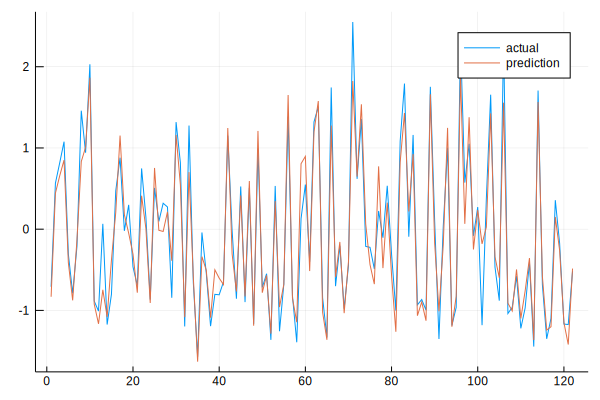

In [243]:
# data preparation
input_schema, output_schema = ML.splitschema(cars_schema,:Weight_in_lbs);
input = ML.featuremat(input_schema,cars)
output = ML.featuremat(output_schema,cars)
train_input,train_output,test_input,test_output = partitionTrainTest(input,output,0.7);
data = [(train_input, train_output)] #|> gpu;

model = fluxregression(data,0.01,1000)
yhat=model(test_input)
y=test_output
rmse = sqrt((y .- yhat.data).^2 |> mean ) 
println("rmse=",rmse)
plot([y' yhat.data'],lab=["actual","prediction"])

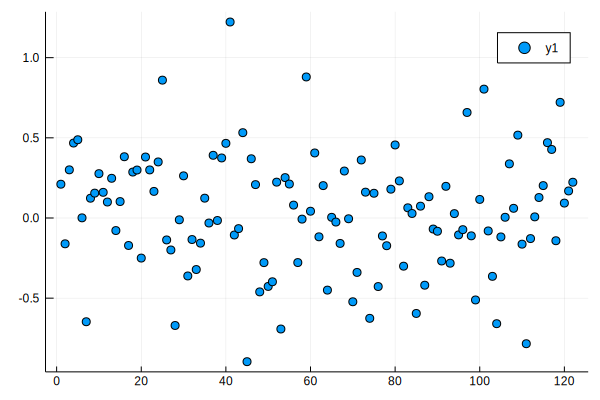

In [127]:
scatter([y' .- yhat.data'])

## Flux Classification

In [283]:
function fluxclassification(data,lr=0.01,iterations=1000,hidden=10,checkpoint=0.1)
    model = Chain(
        Dense(ML.width(input_schema),hidden,relu),
        Dense(hidden,ML.width(output_schema)),
        softmax
    )
     
    loss(x,y) = Flux.mse(model(x),y)

    opt = ADAM(lr) 
    evalcb = Flux.throttle(() -> @show(loss(first(data)...)), checkpoint);
    
    for i = 1:iterations
      Flux.train!(loss, params(model),data, opt, cb = evalcb)
    end
    return model
end
accuracy(x, y) = mean(Flux.onecold(x) .== Flux.onecold(y))*100

accuracy (generic function with 1 method)

In [327]:
input_schema, output_schema = ML.splitschema(cars_schema,:Cylinders);
input = ML.featuremat(input_schema,cars)
output = ML.featuremat(output_schema,cars)
train_input,train_output,test_input,test_output = partitionTrainTest(input,output,0.7)
data = [(train_input, train_output)] 

model = fluxclassification(data,0.1,1000)
yhat=model(test_input)
accuracy(yhat,test_output)

loss(first(data)...) = 0.08954839f0 (tracked)
loss(first(data)...) = 0.007815041f0 (tracked)
loss(first(data)...) = 0.0074611595f0 (tracked)
loss(first(data)...) = 0.0074183946f0 (tracked)
loss(first(data)...) = 0.007422068f0 (tracked)
loss(first(data)...) = 0.007417016f0 (tracked)


96.72131147540983

In [328]:
using RCall

In [329]:
pred = Flux.onecold(yhat.data)
gt = Flux.onecold(test_output);

In [330]:
R"table($pred,$gt)"

RObject{IntSxp}
   
     1  2  3  5
  1 34  0  1  0
  2  0 60  1  1
  3  0  1 24  0


In [331]:
cars |> DataFrame |> x-> x.Cylinders |> x->R"table($x)"

RObject{IntSxp}

  3   4   5   6   8 
  4 207   3  84 108 


## Flux MNIST

### MLP (multi-layer perceptron)

In [346]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated
# using CuArrays

# Classify MNIST digits with a simple multi-layer-perceptron

imgs = MNIST.images()
# Stack images into one large batch
X = hcat(float.(reshape.(imgs, :))...) |> gpu

labels = MNIST.labels()
# One-hot-encode the labels
Y = onehotbatch(labels, 0:9) |> gpu

m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax) |> gpu

loss(x, y) = crossentropy(m(x), y)

accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

fdataset = repeated((X, Y), 50)
evalcb = () -> @show(loss(X, Y))
opt = ADAM()

Flux.train!(loss, params(m), fdataset, opt, cb = throttle(evalcb, 5))

accuracy(X, Y)

# Test set accuracy
tX = hcat(float.(reshape.(MNIST.images(:test), :))...) |> gpu
tY = onehotbatch(MNIST.labels(:test), 0:9) |> gpu

accuracy(tX, tY)

loss(X, Y) = 2.308472f0 (tracked)
loss(X, Y) = 1.7174263f0 (tracked)
loss(X, Y) = 1.2651258f0 (tracked)
loss(X, Y) = 0.9309746f0 (tracked)
loss(X, Y) = 0.7198473f0 (tracked)


0.8463

### Convolution layers

In [ ]:
using Flux, Metalhead, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Metalhead: trainimgs
using Images: channelview
using Statistics: mean
using Base.Iterators: partition

# VGG16 and VGG19 models

vgg16() = Chain(
  Conv((3, 3), 3 => 64, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(64),
  Conv((3, 3), 64 => 64, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(64),
  x -> maxpool(x, (2, 2)),
  Conv((3, 3), 64 => 128, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(128),
  Conv((3, 3), 128 => 128, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(128),
  x -> maxpool(x, (2,2)),
  Conv((3, 3), 128 => 256, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(256),
  Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(256),
  Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(256),
  x -> maxpool(x, (2, 2)),
  Conv((3, 3), 256 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  x -> maxpool(x, (2, 2)),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
  BatchNorm(512),
  x -> maxpool(x, (2, 2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(512, 4096, relu),
  Dropout(0.5),
  Dense(4096, 4096, relu),
  Dropout(0.5),
  Dense(4096, 10),
  softmax) |> gpu


# Function to convert the RGB image to Float64 Arrays

getarray(X) = Float32.(permutedims(channelview(X), (2, 3, 1)))

# Fetching the train and validation data and getting them into proper shape

X = trainimgs(CIFAR10)
imgs = [getarray(X[i].img) for i in 1:50000]
labels = onehotbatch([X[i].ground_truth.class for i in 1:50000],1:10)
train = gpu.([(cat(imgs[i]..., dims = 4), labels[:,i]) for i in partition(1:49000, 100)])
valset = collect(49001:50000)
valX = cat(imgs[valset]..., dims = 4) |> gpu
valY = labels[:, valset] |> gpu

# Defining the loss and accuracy functions

m = vgg16()

loss(x, y) = crossentropy(m(x), y)

accuracy(x, y) = mean(onecold(m(x), 1:10) .== onecold(y, 1:10))

# Defining the callback and the optimizer

evalcb = throttle(() -> @show(accuracy(valX, valY)), 10)

opt = ADAM()

# Starting to train models

Flux.train!(loss, params(m), train, opt, cb = evalcb)

# Fetch the test data from Metalhead and get it into proper shape.
# CIFAR-10 does not specify a validation set so valimgs fetch the testdata instead of testimgs

test = valimgs(CIFAR10)

testimgs = [getarray(test[i].img) for i in 1:10000]
testY = onehotbatch([test[i].ground_truth.class for i in 1:10000], 1:10) |> gpu
testX = cat(testimgs..., dims = 4) |> gpu

# Print the final accuracy

@show(accuracy(testX, testY))